# DataJoint Workflow Calcium Imaging

+ This notebook will describe the steps for interacting with the data ingested into `workflow-calcium-imaging`.  

In [1]:
import os
os.chdir('..')

In [2]:
import datajoint as dj
import matplotlib.pyplot as plt
import numpy as np

from workflow_calcium_imaging.pipeline import lab, subject, session, scan, imaging

Connecting user1@127.0.0.1:3306


## Workflow architecture

This workflow is assembled from 4 DataJoint elements:
+ [element-lab](https://github.com/datajoint/element-lab)
+ [element-animal](https://github.com/datajoint/element-animal)
+ [element-session](https://github.com/datajoint/element-session)
+ [element-calcium-imaging](https://github.com/datajoint/element-calcium-imaging)

For the architecture and detailed descriptions for each of those elements, please visit the respective links. 

Below is the diagram describing the core components of the fully assembled pipeline.


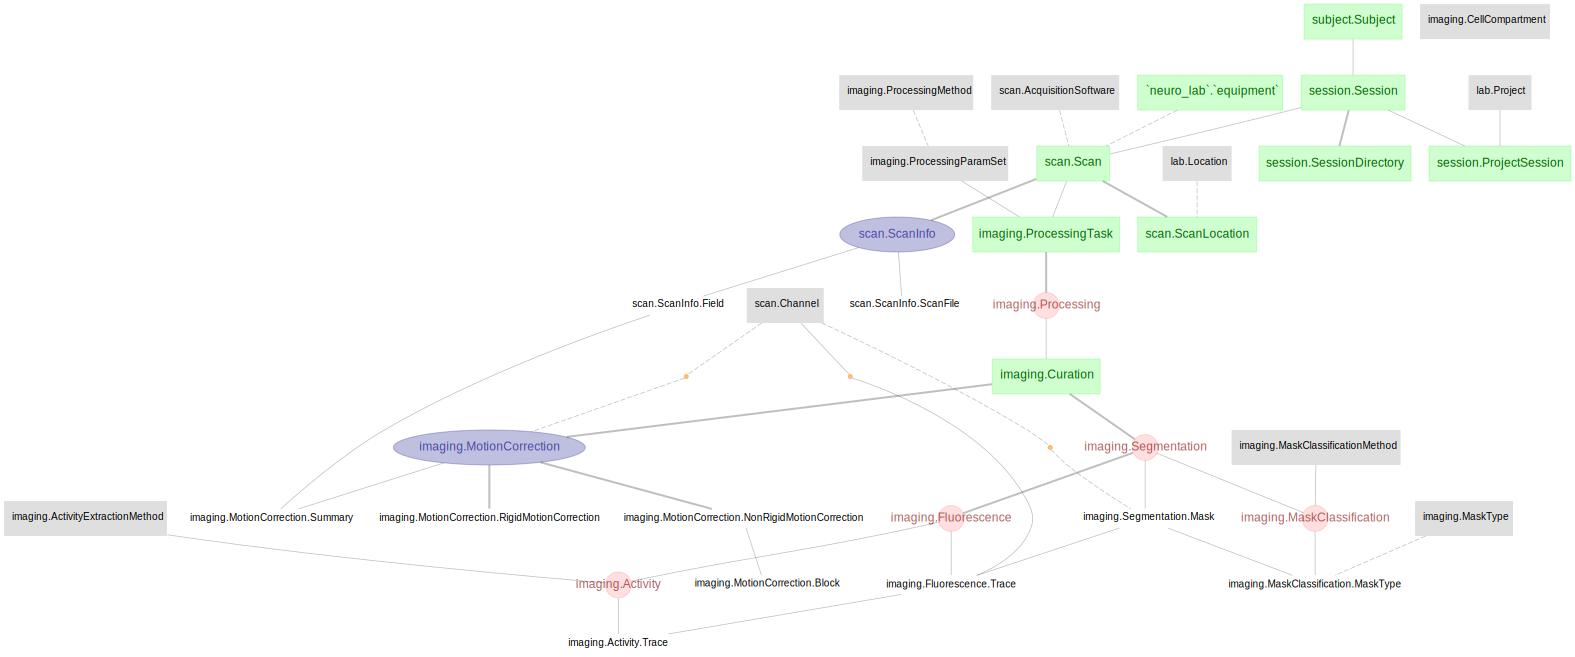

In [3]:
dj.Diagram(imaging) + dj.Diagram(scan) + (dj.Diagram(session.Session) + 1) - 1

## Browsing the data with DataJoint `query` and `fetch` 

+ DataJoint provides functions to query data and fetch.  For a detailed tutorials, visit our [general tutorial site](https://playground.datajoint.io/).

+ Running through the pipeline, we have ingested data of subject3 into the database.

+ Here are some highlights of the important tables.

### `subject.Subject` and `session.Session` tables

In [4]:
subject.Subject()

subject,sex,subject_birth_date,subject_description
subject3,F,2020-01-01,Scanbox acquisition. Suite2p processing.


In [5]:
session.Session()

subject,session_datetime
subject3,2021-04-30 12:22:15.032000


+ Fetch the primary key for the session of interest which will be used later on in this notebook.

In [6]:
session_key = (session.Session & 'subject = "subject3"' & 'session_datetime = "2021-04-30 12:22:15.032"').fetch1('KEY')

### `scan.Scan` and `scan.ScanInfo` tables

+ These tables stores the scan metadata within a particular session.

In [7]:
scan.Scan & session_key

subject,session_datetime,scan_id,scanner,acq_software,scan_notes free-notes
subject3,2021-04-30 12:22:15.032000,0,Scanbox,Scanbox,


In [8]:
scan.ScanInfo & session_key

subject,session_datetime,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage)
subject3,2021-04-30 12:22:15.032000,0,4,1,4,7530,0,0.0,0.0,-311.71,7.8125,0,nan,nan


In [9]:
scan.ScanInfo.Field & session_key

subject,session_datetime,scan_id,field_idx,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,field_x (um) center of field in the motor coordinate system,field_y (um) center of field in the motor coordinate system,field_z (um) relative depth of field,delay_image (ms) delay between the start of the scan and pixels in this field,roi the scanning roi (as recorded in the acquisition software) containing this field - only relevant to mesoscale scans
subject3,2021-04-30 12:22:15.032000,0,0,796,512,nan,nan,0.0,0.0,-108.71,=BLOB=,None
subject3,2021-04-30 12:22:15.032000,0,1,796,512,nan,nan,0.0,0.0,-56.71,=BLOB=,None
subject3,2021-04-30 12:22:15.032000,0,2,796,512,nan,nan,0.0,0.0,2.29,=BLOB=,None
subject3,2021-04-30 12:22:15.032000,0,3,796,512,nan,nan,0.0,0.0,67.29,=BLOB=,None


### `imaging.ProcessingParamSet`, `imaging.ProcessingTask`, `imaging.Processing`, and `imaging.Curation` tables

+ The parameters used for Suite2p or CaImAn are stored in `imaging.ProcessingParamSet` under a `paramset_idx`.

+ The processing details for Suite2p and CaImAn are stored in `imaging.ProcessingTask` and `imaging.Processing` for the utilized `paramset_idx`.

+ After the motion correction and segmentation, the results may go through a curation process. 
    
    + If it did not go through curation, a copy of the `imaging.ProcessingTask` entry is inserted into `imaging.Curation` with the `curation_output_dir` identical to the `processing_output_dir`.

    + If it did go through a curation, a new entry will be inserted into `imaging.Curation`, with a `curation_output_dir` specified.

    + `imaging.Curation` supports multiple curations of an entry in `imaging.ProcessingTask`.

In [10]:
imaging.ProcessingParamSet()

paramset_idx,processing_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,suite2p,Calcium imaging analysis with Suite2p using default Suite2p parameters,be32de46-f21d-d714-d131-ec89817de806,=BLOB=


In [11]:
imaging.ProcessingTask * imaging.Processing & session_key

subject,session_datetime,scan_id,paramset_idx,processing_output_dir output directory of the processed scan relative to root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation","processing_time time of generation of this set of processed, segmented results",package_version
subject3,2021-04-30 12:22:15.032000,0,0,subject3/210107_run00_orientation_8dir/suite2p,load,2021-04-30 11:26:55,


In this example workflow, `curation_output_dir` is the same as the `processing_output_dir`, as these results were not manually curated.

In [12]:
imaging.Curation & session_key

subject,session_datetime,scan_id,paramset_idx,curation_id,curation_time time of generation of this set of curated results,"curation_output_dir output directory of the curated results, relative to root data directory",manual_curation has manual curation been performed on this result?,curation_note
subject3,2021-04-30 12:22:15.032000,0,0,0,2021-04-30 12:22:15,subject3/210107_run00_orientation_8dir/suite2p,0,


### `imaging.MotionCorrection` table

+ After processing and curation, results are passed to the `imaging.MotionCorrection` and `imaging.Segmentation` tables.

+ For the example data, the raw data is corrected with rigid and non-rigid motion correction which is stored in `imaging.MotionCorrection.RigidMotionCorrection` and `imaging.MotionCorrection.NonRigidMotionCorrection`, respectively. 

+ Lets first query the information for one curation.

In [13]:
curation_key = (imaging.Curation & session_key & 'curation_id=0').fetch1('KEY')

In [14]:
curation_key

{'subject': 'subject3',
 'session_datetime': datetime.datetime(2021, 4, 30, 12, 22, 15, 32000),
 'scan_id': 0,
 'paramset_idx': 0,
 'curation_id': 0}

In [15]:
imaging.MotionCorrection.RigidMotionCorrection & curation_key

subject,session_datetime,scan_id,paramset_idx,curation_id,outlier_frames mask with true for frames with outlier shifts (already corrected),y_shifts (pixels) y motion correction shifts,x_shifts (pixels) x motion correction shifts,z_shifts (pixels) z motion correction shifts (z-drift),y_std (pixels) standard deviation of y shifts across all frames,x_std (pixels) standard deviation of x shifts across all frames,z_std (pixels) standard deviation of z shifts across all frames
subject3,2021-04-30 12:22:15.032000,0,0,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,0.689302,1.4812,nan


In [16]:
imaging.MotionCorrection.NonRigidMotionCorrection & curation_key

subject,session_datetime,scan_id,paramset_idx,curation_id,outlier_frames mask with true for frames with outlier shifts (already corrected),block_height (pixels),block_width (pixels),block_depth (pixels),block_count_y number of blocks tiled in the y direction,block_count_x number of blocks tiled in the x direction,block_count_z number of blocks tiled in the z direction
subject3,2021-04-30 12:22:15.032000,0,0,0,=BLOB=,128,128,1,6,9,4


+ For non-rigid motion correction, the details for the individual blocks are stored in `imaging.MotionCorrection.Block`.

In [17]:
imaging.MotionCorrection.Block & curation_key & 'block_id=0'

subject,session_datetime,scan_id,paramset_idx,curation_id,block_id,"block_y (y_start, y_end) in pixel of this block","block_x (x_start, x_end) in pixel of this block","block_z (z_start, z_end) in pixel of this block",y_shifts (pixels) y motion correction shifts for every frame,x_shifts (pixels) x motion correction shifts for every frame,z_shifts (pixels) x motion correction shifts for every frame,y_std (pixels) standard deviation of y shifts across all frames,x_std (pixels) standard deviation of x shifts across all frames,z_std (pixels) standard deviation of z shifts across all frames
subject3,2021-04-30 12:22:15.032000,0,0,0,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,0.95889,1.28989,nan


+ Summary images are stored in `imaging.MotionCorrection.Summary`

    + Reference image - image used as an alignment template

    + Average image - mean of registered frames

    + Correlation image - correlation map (computed during region of interest \[ROI\] detection)

    + Maximum projection image - max of registered frames

In [18]:
imaging.MotionCorrection.Summary & curation_key & 'field_idx=0'

subject,session_datetime,scan_id,paramset_idx,curation_id,field_idx,ref_image image used as alignment template,average_image mean of registered frames,correlation_image correlation map (computed during cell detection),max_proj_image max of registered frames
subject3,2021-04-30 12:22:15.032000,0,0,0,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=


+ Lets fetch the `average_image` and plot it.

In [19]:
average_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('average_image')

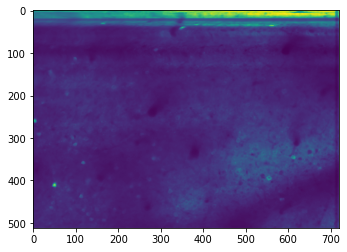

In [20]:
plt.imshow(average_image);

### `imaging.Segmentation` table

+ Lets fetch and plot a mask stored in the `imaging.Segmentation.Mask` table for one `curation_id`.

+ Each mask can be associated with a field by the attribute `mask_center_z`.  For example, masks with `mask_center_z=0` are in the field identified with `field_idx=0` in `scan.ScanInfo.Field`.

In [21]:
mask_xpix, mask_ypix = (imaging.Segmentation.Mask * imaging.MaskClassification.MaskType & curation_key & 'mask_center_z=0' & 'mask_npix > 130').fetch('mask_xpix','mask_ypix')

In [22]:
mask_image = np.zeros(np.shape(average_image), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    mask_image[ypix, xpix] = True

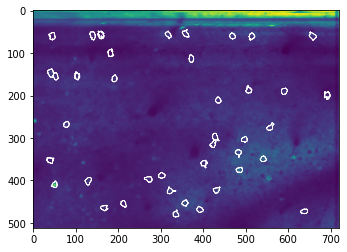

In [23]:
plt.imshow(average_image);
plt.contour(mask_image, colors='white', linewidths=0.5);

### `imaging.MaskClassification` table

+ This table provides the `mask_type` and `confidence` for the mask classification.

In [24]:
imaging.MaskClassification.MaskType & curation_key & 'mask=0'

subject,session_datetime,scan_id,paramset_idx,curation_id,mask_classification_method,mask,mask_type,confidence
subject3,2021-04-30 12:22:15.032000,0,0,0,suite2p_default_classifier,0,soma,0.977439


### `imaging.Fluorescence` table

+ Lets fetch and plot the flourescence and neuropil fluorescence traces for one mask.

In [25]:
fluorescence_trace, neuropil_fluorescence_trace = (imaging.Fluorescence.Trace & curation_key & 'mask=0').fetch1('fluorescence', 'neuropil_fluorescence')

sampling_rate = (scan.ScanInfo & curation_key).fetch1('fps') # [Hz]

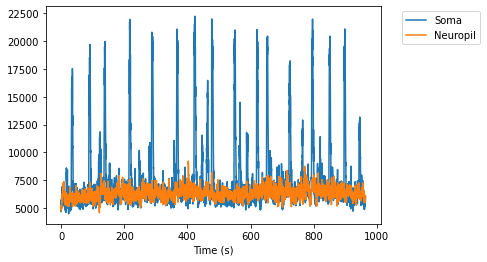

In [26]:
plt.plot(np.r_[:fluorescence_trace.size] * 1/sampling_rate, 
         fluorescence_trace, 
         label='Soma')

plt.plot(np.r_[:neuropil_fluorescence_trace.size] * 1/sampling_rate, 
         neuropil_fluorescence_trace, 
         label='Neuropil')

plt.legend(bbox_to_anchor=(1.05,1))
plt.xlabel('Time (s)');

### `imaging.Activity` table

In [27]:
activity_trace = (imaging.Activity.Trace & curation_key & 'mask=0').fetch1('activity_trace')

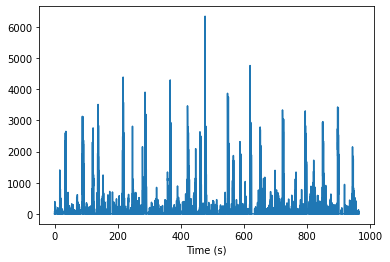

In [28]:
plt.plot(np.r_[:activity_trace.size] * 1/sampling_rate, 
         activity_trace, 
         label='Soma');

plt.xlabel('Time (s)');

## Summary and Next Step

+ This notebook highlights the major tables in the workflow and visualize some of the ingested results. 

+ The next notebook [06-drop](06-drop-optional.ipynb) shows how to drop schemas and tables if needed.